In [4]:
library(dplyr)
library("ggpubr")
samples<-read.csv("./named/pgbench_all/ebs_backed/pgbench_16*c4.large_60s_1to16_labeled.csv")

# Experiment Description

## overview

In [ ]:
Running database(pgbench) workload on a AWS dedicated host.
That host can provision 16*c4.large VMs.
Each time only part of VMs work actively.
                  |VM1 |
                   ...
       |VM15| ... |VM15|
|VM16| |VM16| ... |VM16|
--------------------------> Time line
  set1  set2  ... set16.    Experiment name

## details

- Each _|VMx|_ block described on above time line consist of **3** runs.
- Thus, in the _.csv_ file **3** entries are labeled **set:=1**.
- Further more, **48** (=3\*16) entries are labeled by **vmID:=16**

Each entry of the _.csv_ file is generated by following command
> $pgbench --client=10 --jobs=10 --time=60  ubuntu

 '10 connections are created by 10 clients targeting to postgreSQL server'<br>
 'pgbench is going to use 1- threads to handle all connections if possible'<br>
 'pgbench will proceed performance test until the limit of 60 seconds'

# Analysis

## indicators of whole experiment

In [5]:
wholeExp = samples[,'transactions']
indicators=data.frame()
indicators<-rbind(indicators,c(range(wholeExp),mean(wholeExp),median(wholeExp)))
names(indicators)<-c('min','max','mean','median')
indicators

min   max   mean    median
1 49334 72871 58389.5 57128

### (max-min)/min

In [17]:
(72871-49334)/49334


[1] 0.4770949

### mean && 95percentile

In [4]:
percentile=data.frame(quantile(samples$transactions,c(0.5,0.95)))
names(percentile) <- c('mean && 95percentile')
percentile

mean && 95percentile
50% 57128               
95% 70631

### Graph1 distribution

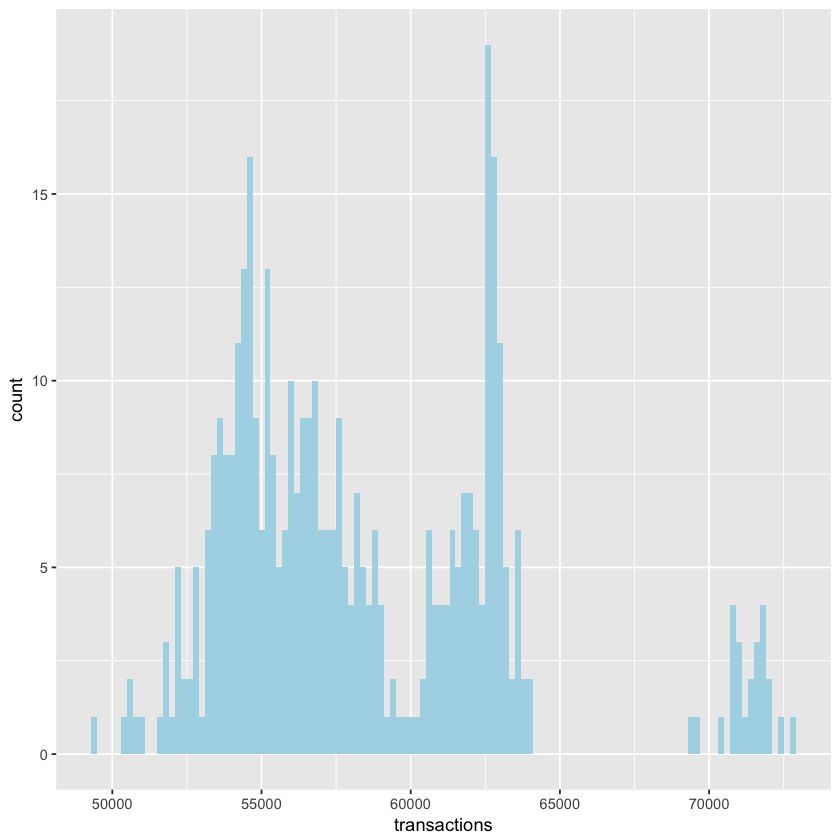

In [25]:
ggplot(samples, aes(x = transactions)) +
  geom_histogram(binwidth = 200, fill = "lightblue",)+
scale_x_continuous(breaks = scales::pretty_breaks()) +
scale_y_continuous(breaks = scales::pretty_breaks())

### brief summary

- If all the bars which have over 70,000 transactions are belongs to test **set1**
then I would say performance degradation is fairly obvious.
- (max-min)/min, **~47.7%**, is much larger than what we got when conserning CPU

## indicators of each test set 

In [26]:
statistic_result=data.frame()
for(i in 1:16){
    thisSet=samples[samples$set==i,'transactions']
    statistic_result=rbind(statistic_result,c(range(thisSet),mean(thisSet),median(thisSet),var(thisSet),i))
}
names(statistic_result)<-c('min','max','mean','median','var','set')
statistic_result

min   max   mean     median  var      set
1  50637 53321 52219.67 52701.0  1974725  1 
2  54518 61481 57937.83 57970.5 12027028  2 
3  55132 62793 59921.78 61650.0 10779164  3 
4  55322 62898 59404.58 58685.0  9034218  4 
5  54438 63768 58648.47 56672.0 13795827  5 
6  52227 63949 58857.17 58398.5 13471148  6 
7  50695 62525 56820.86 55545.0 17982405  7 
8  53234 63074 57793.67 56672.0 14327765  8 
9  53357 70852 59739.26 58018.0 27003768  9 
10 49334 72305 59317.07 58413.5 35989309 10 
11 51632 71733 58587.15 56949.0 30616424 11 
12 51756 71806 58537.92 57199.0 26791842 12 
13 51050 72871 58376.62 57205.0 28639950 13 
14 52765 71438 58476.62 57129.5 22458627 14 
15 52852 71940 58051.80 56810.0 20216373 15 
16 52479 70984 57683.08 56256.5 20646923 16

In [32]:
(57683.08-52219.67)/52219.67

[1] 0.1046236

### Graph2 distribution of each (set,vmID) pair

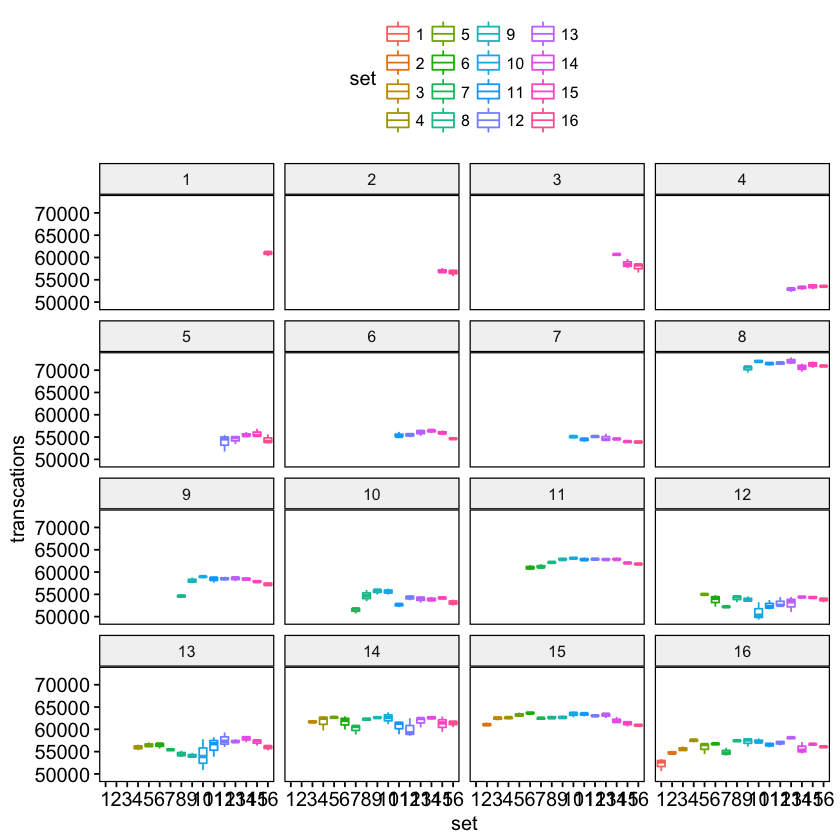

In [6]:
ggboxplot(samples, x = "set", y = "transactions", 
          color = "set", 
          ylab = "transcations", xlab = "set",facet.by='vmID')



In [ ]:
Note:
                  |VM1 |
                   ...
       |VM15| ... |VM15|
|VM16| |VM16| ... |VM16|
--------------------------> Time line
  set1  set2  ... set16.    Experiment name

### brief summary
- both indicators and graph show that the fact is on opposite of my expectation 
- **set1** only proceeded **52219.67** transactions on average whereas **set1** has most idle environment
- every box in the graph above present a VM(instance() which means the **8th** VM reach the best performance when it was procedding SQL database transactions.

# Conclusion

The pattern of this DB test is totally different from our former CPU test.

In the previous test, we got a obvious trending shows that average computation time is increasing while we are involving more and more actively computing VMs. No matter we view the data from a set-average or VM-respective dimension. While we only got **~5.6%** diffence between best-performed set and the worst one, but all the clues nevertheless hinted a same result. 

On the surface, we got around **10%** diffence between best set and the worst set in this test and **47%** amoung extreme values. But graph2 shows totally another sotry. Entries with transactions greater than **70,000** all fall in instance *i-05beae02d7745c9bc* which is labeled as **vmID:=8**. Meanwhile, test set involving the **8th** VM at least has 9 VMs running database test concurently. In a word, the most weird thing is we got best performance that is far beyond others at a quite worst enviornment.

I tried to switch the view of each *VM* to the view of each *set* and found that transactions are sparse within a set. Even took both DB cache and some other training effect into consideration I still couldn't explan the phenomenon convincingly.

A bold guess is that database performance is bound to instance.
